# Overview

Add our overview narrative here!!!!


In [42]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

## Encoder

This **Encoder** class is a part of the larger sequence-to-sequence model designed for processing mathematical word problems using an **LSTM**. It takes input sequences (math questions) represented as token indices and converts them into dense vector embeddings using an embedding layer, allowing the model to capture meaningful semantic relationships between words. The embedded representations then pass through an LSTM layer, which extracts temporal dependencies and generates both hidden and cell states that encode contextual information about the question sequence. A dropout layer is applied to the embeddings to reduce overfitting and improve generalisation. Ultimately, the encoder produces a set of outputs from each time step and a final hidden representation, which the decoder later uses to generate responses (the expected answer to our math question).

In [43]:
class Encoder(nn.Module):
    """ 
    Encoder for the sequence-to-sequence math problem assistant model using an LSTM. 
    Converts a sequence of token indices into a hidden representation 
    that will be used by the decoder for sequence generation.
    """
    def __init__(self, input_size, hidden_size, dropout=0.1):
        """
        Initialises the Encoder module.
        Args:
            input_size (int): The size of the input vocabulary.
            hidden_size (int): The number of hidden units in the LSTM.
            dropout (float): Dropout rate to prevent overfitting.
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        # Embedding layer converts token indices into dense vector representations.
        # Instead of using raw word indices (which lack meaning), embeddings allow
        # the LSTM to learn meaningful semantic relationships between words.
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer processes embedded input sequences to generate hidden states.
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        # Dropout layer applied to embeddings to prevent overfitting.
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seq):
        """
        Forward pass through the encoder.
        Args:
            input_seq (Tensor): Tensor containing token indices for a batch of input sentences.
        Returns:
            outputs (Tensor): Encoder outputs at each time step.
            hidden (Tensor): Final hidden state of the LSTM.
            cell (Tensor): Final cell state of the LSTM.
        """
        embedded = self.embedding(input_seq)           # Convert input tokens into embeddings
        embedded = self.dropout(embedded)             # Apply dropout before LSTM processing
        outputs, (hidden, cell) = self.lstm(embedded) # Process embeddings through LSTM

        return outputs, (hidden, cell)

## Attention

The **Attention** class implements **'Bahdanau attention'**, which dynamically calculates attention scores based on the decoder’s hidden state and the encoder’s outputs. Instead of relying on a fixed context vector, this method allows the decoder to focus on specific parts of the input sequence at each decoding step. The attention mechanism works by concatenating the decoder's hidden state with the encoder’s outputs, passing them through a linear transformation, and applying the tanh activation function. A learnable vector (**v**) helps compute alignment scores, which are then normalised using softmax to generate attention weights—these determine the importance of each encoder output when predicting the next token. A dropout layer is also applied to prevent overfitting. The output is a set of attention weights that guides the decoder in generating more context-aware responses.

In [44]:
import torch
import torch.nn as nn

class Attention(nn.Module):
    """ 
    Implements Bahdanau attention mechanism for a sequence-to-sequence model. 
    Dynamically computes attention scores based on the decoder’s hidden state 
    and the encoder’s outputs, allowing the decoder to focus on relevant 
    parts of the input sequence at each decoding step.
    """
    def __init__(self, hidden_size, dropout=0.1):
        """
        Initializes the attention mechanism.
        Args:
            hidden_size (int): The size of the hidden state of the LSTM.
            dropout (float): Dropout rate to prevent overfitting.
        """
        super(Attention, self).__init__()
        # Linear layer to compute alignment scores
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        # Learnable vector for attention computation
        self.v = nn.Parameter(torch.rand(hidden_size))
        # Dropout layer to regularize attention mechanism
        self.dropout = nn.Dropout(dropout)

    def forward(self, hidden, encoder_outputs):
        """
        Computes attention weights using Bahdanau's additive attention method.
        Args:
            hidden (Tensor): Decoder hidden state at the current time step.
            encoder_outputs (Tensor): Encoder outputs at all time steps.
        Returns:
            attention_weights (Tensor): Softmax-normalized attention scores.
        """
        seq_len = encoder_outputs.size(1)
        batch_size = encoder_outputs.size(0)
        # Expand the decoder hidden state across the sequence length
        hidden = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        # Concatenate hidden state with encoder outputs to compute alignment scores
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # Apply dropout to energy scores before computing attention weights
        energy = self.dropout(energy)
        # Compute attention weights using a dot-product operation
        v = self.v.unsqueeze(0).expand(batch_size, -1).unsqueeze(1)  # Ensure proper batch handling
        attention_weights = torch.bmm(v, energy.transpose(1, 2)).squeeze(1)
        # Apply softmax to normalize scores across sequence length
        return torch.softmax(attention_weights, dim=1)

## Decoder

The Decoder class plays a crucial role in our sequence-to-sequence model designed to solve math word problems. When given a problem as an input sequence, the Encoder first processes it into a hidden representation, which the Decoder then uses to generate the solution step by step. At each step, the attention mechanism dynamically selects the most relevant parts of the encoded problem statement, allowing the Decoder to focus on specific numerical relationships and mathematical operations. The LSTM maintains contextual understanding across time steps, helping track dependencies between numbers and mathematical operators. As the model generates each token in the solution, it refines its prediction using previously computed values, making the process similar to how humans break down word problems into logical steps. This structure ensures that the model interprets and solves math problems contextually, rather than simply memorising formulas, enabling it to generalise across different problem types.

In [45]:
class Decoder(nn.Module):
    """ 
    Decoder for the sequence-to-sequence math problem assistant model using an 
    LSTM with Bahdanau attention. The decoder generates output tokens one by one 
    while dynamically focusing on relevant parts of the encoder’s outputs using 
    the attention mechanism.
    """
    def __init__(self, output_size, hidden_size, dropout=0.1):
        """
        initialises the Decoder module.

        Args:
            output_size (int): The size of the output vocabulary.
            hidden_size (int): The number of hidden units in the LSTM.
            dropout (float): Dropout rate to prevent overfitting.
        """
        super(Decoder, self).__init__()
        # Embedding layer converts token indices into dense vectors
        self.embedding = nn.Embedding(output_size, hidden_size)
        # LSTM layer processes embeddings and maintains hidden state across timesteps
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        # Linear layer maps concatenated attention context & LSTM output to vocab space
        self.fc = nn.Linear(hidden_size * 2, output_size)
        # Dropout layer to regularise embeddings before passing them to LSTM
        self.dropout = nn.Dropout(dropout)  
        # Attention mechanism for dynamic focus on encoder outputs
        self.attention = Attention(hidden_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        """
        Forward pass for the decoder.
        Args:
            input (Tensor): Current token input to the decoder.
            hidden (Tensor): Previous hidden state from the LSTM.
            cell (Tensor): Previous cell state from the LSTM.
            encoder_outputs (Tensor): Encoder outputs from all timesteps.

        Returns:
            output (Tensor): Predicted token probabilities.
            hidden (Tensor): Updated hidden state.
            cell (Tensor): Updated cell state.
            attention_weights (Tensor): Attention scores for each encoder timestep.
        """
        # Expand input dimensions to match expected input shape for embedding
        input = input.unsqueeze(1)  
        # Convert token indices into dense embeddings & apply dropout for regularisation
        embedded = self.dropout(self.embedding(input))
        # Forward pass through LSTM to generate new hidden and cell states
        lstm_output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # Compute attention weights using the current hidden state and encoder outputs
        attention_weights = self.attention(hidden[-1], encoder_outputs)
        # Apply attention: generate weighted sum of encoder outputs
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)
        # Flatten tensors for the fully connected layer
        lstm_output = lstm_output.squeeze(1)
        context = context.squeeze(1)
        # Generate token probabilities using concatenated LSTM output and attention context
        output = self.fc(torch.cat((lstm_output, context), dim=1))

        return output, hidden, cell, attention_weights

##  Basic tokenisation and vocabulary Setup

Here we set up the constants and tokenisation process for a sequence-to-sequence math problem assistant. It first defines special tokens **<SOS>**, **<EOS>**, and **<PAD>** to mark the start, end, and padding of sequences. Then, it creates a vocabulary mapping that converts words into numerical indices, allowing the model to process text as numbers. The reverse mapping (**index_to_word**) ensures that predictions can be decoded back into words. Finally, the script tokenises example input and target sequences, transforming for example, **"two plus four"** into a list of indices **[3, 4, 5]** and the target **"equals six"** into **[0, 6, 7, 1]**, ensuring that the decoder starts with <SOS> and ends with <EOS>. This setup enables the neural network to work with structured input-output pairs for training our expected math-solving model.

In [46]:
#Estalish constants
START_OF_SEQUENCE_TOKEN = "<SOS>"
END_OF_SEQUENCE_TOKEN = "<EOS>"
PADDING_SEQUENCE_TOKEN = "<PAD>"

# Tokenisation and vocab setup
# Create a vocabulary mapping words to indices
word_to_index = {START_OF_SEQUENCE_TOKEN: 0, END_OF_SEQUENCE_TOKEN: 1, PADDING_SEQUENCE_TOKEN: 2, "two": 3, "plus": 4, "four": 5, "equals": 6, "six": 7, "three": 8, "minus": 9, "one": 10}
index_to_word = {v: k for k, v in word_to_index.items()}  # Reverse mapping for decoding

# Example input and target sequences
input_sentence = "two plus four"
target_sentence = "equals six"

# Test Tokenised input and targets
input_tokens = [word_to_index[word] for word in input_sentence.split()]
target_tokens = [word_to_index[START_OF_SEQUENCE_TOKEN]] + [word_to_index[word] for word in target_sentence.split()] + [word_to_index[END_OF_SEQUENCE_TOKEN]]

## Generate the math problem dataset from the tokensied data

This **BasicMathWordProblemDataset** class creates a custom PyTorch Dataset for training our sequence-to-sequence model that solves basic math word problems. It converts input and target sentences (our math questions) into lists of token indices using a predefined vocabulary (**word_to_index**). The target sequence is prepended with <SOS> and appended with <EOS> tokens to indicate the start and end of the output. The class implements essential dataset methods, notablu __len__() which returns the number of samples, while __getItem__() retrieves tokenised tensors for input and target sequences, ensuring compatibility with PyTorch models. Finally, the dataset is wrapped in a DataLoader, allowing efficient batch processing with shuffling to improve learning dynamics.

In [47]:
class BasicMathWordProblemDataset(Dataset):
    """
    A PyTorch Dataset for tokenised math word problems.
    This class converts input sentences into tokenised sequences using 
    a predefined vocabulary (`word_to_index`) and structures target 
    sequences with <SOS> (start-of-sequence) and <EOS> (end-of-sequence) 
    tokens for proper handling by the decoder.
    """
    def __init__(self, input_sentences, target_sentences, word_to_index):
        """
        initialises the dataset by converting words into token indices.
        Args:
            input_sentences (list of str): List of math word problems (input).
            target_sentences (list of str): Corresponding solutions (output).
            word_to_index (dict): Mapping of words to numerical token indices.
        """
        # Tokenise input sentences into numerical sequences
        self.input_data = [[word_to_index[word] for word in sentence.split()] for sentence in input_sentences]
        # Tokenise target sentences while adding special tokens <SOS> and <EOS>
        self.target_data = [[word_to_index[START_OF_SEQUENCE_TOKEN]] + 
                            [word_to_index[word] for word in sentence.split()] + 
                            [word_to_index[END_OF_SEQUENCE_TOKEN]] for sentence in target_sentences]

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        Returns:
            int: Total number of input-target pairs.
        """
        return len(self.input_data)

    def __getitem__(self, idx):
        """
        Retrieves the tokenised input and target sequences as PyTorch tensors.
        Args:
            idx (int): Index of the data sample.
        Returns:
            Tuple[Tensor, Tensor]: Tokenised input and target sequences.
        """
        return torch.tensor(self.input_data[idx], dtype=torch.long), torch.tensor(self.target_data[idx], dtype=torch.long)

# Example data
input_sentences = ["two plus four"]
target_sentences = ["equals six"]

# Create dataset and dataloader
dataset = BasicMathWordProblemDataset(input_sentences, target_sentences, word_to_index)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

## Establish hyperparameters

Here we initialise the key components for training our sequence-to-sequence math word problem solving model. The encoder and decoder are instantiated with the vocabulary size (**input_size** and **output_size**) and a hidden state of **128**, allowing the model to process and generate our math solutions. The **CrossEntropy loss function** is used with padding tokens ignored to prevent unnecessary calculations from affecting training. Adam optimisers are applied to both the encoder and decoder with a learning rate of **0.001**, enabling stable gradient updates. Finally, an attention matrix is initialised to store attention weights, which will later be used for visualisation, thus helping to analyse how the model focuses on different parts of the input when generating solutions.

In [48]:
# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the encoder and decoder
input_size = len(word_to_index)  # Total vocabulary size
output_size = len(word_to_index)  # Vocabulary size
hidden_size = 128

encoder = Encoder(input_size, hidden_size).to(device)
decoder = Decoder(output_size, hidden_size).to(device)

# Ignore padding tokens
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PADDING_SEQUENCE_TOKEN])  
encoder_optimiser = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimiser = optim.Adam(decoder.parameters(), lr=0.001)

# Store attention weights for visualisation
attention_matrix = []  

## Plot training loss over epochs

This function visualises the training loss over epochs using Matplotlib. It takes a list of loss values (**epoch_losses**), representing the loss at each epoch, and plots them on a graph to track performance trends over time. This is useful for monitoring model convergence and diagnosing potential issues such as overfitting or slow learning.

In [49]:
import matplotlib.pyplot as plt

def plot_loss(epoch_losses):
    """
    Plots the training loss over epochs.
    Args:
        epoch_losses (list): A list containing the loss values for each epoch.
    """
    # Create a figure with a predefined size for better readability
    plt.figure(figsize=(8, 6))
    # Plot the loss values over epochs with markers for each epoch
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label='Training Loss')
    # Label the x-axis to indicate the epoch number
    plt.xlabel("Epoch")
    # Label the y-axis to indicate the loss value
    plt.ylabel("Loss")
    # Add a title to the plot for better context
    plt.title("Training Loss Over Epochs")
    # Display a legend to clarify the plotted line
    plt.legend()
    # Add a grid to improve readability of the trend
    plt.grid()
    # Show the final plot
    plt.show()

## Establish the training regime

This **train()** function is responsible for training our sequence-to-sequence model with an encoder-decoder architecture with **'Bahdanau attention'**. It iterates through a dataset of tokenised math problems for multiple epochs, processing each batch by passing inputs through the encoder, which generates a context vector. The decoder then predicts output tokens step by step, using teacher forcing to guide learning while dynamically focusing on relevant parts of the input via attention mechanisms. The function tracks masked loss, ensuring that padding tokens don't affect optimisation, and updates model weights using backpropagation with **Adam optimisers**. After training, it stores attention weights for visualisation, logs epoch losses, plots them for monitoring, and saves the trained models to disk.

In [50]:
def train(num_epochs, encoder_save_name, decoder_save_name):
    """
    Trains the sequence-to-sequence model using an encoder-decoder architecture.
    Args:
        num_epochs (int): Number of training epochs.
        encoder_save_name (str): File name for saving the trained encoder model.
        decoder_save_name (str): File name for saving the trained decoder model.
    """
    epoch_losses = []  # Stores loss values for tracking progress

    for epoch in range(num_epochs):
        epoch_loss = 0  # Accumulate total loss for the epoch

        for input_seq, target_seq in dataloader:
            # Move data to GPU if available
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            # Reset gradients before each batch
            encoder_optimiser.zero_grad()
            decoder_optimiser.zero_grad()
            # Encoder forward pass - processes input sequences to generate hidden states
            encoder_outputs, (hidden, cell) = encoder(input_seq)
            # Decoder initialisation - starts with the encoder's final hidden state
            decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE_TOKEN]] * input_seq.size(0), device=device)
            decoder_hidden, decoder_cell = hidden, cell
            # Get actual sequence lengths (excluding padding)
            target_lengths = (target_seq != word_to_index[PADDING_SEQUENCE_TOKEN]).sum(dim=1)
            max_target_length = target_lengths.max().item()

            loss = 0  # Tracks batch loss
            
            # Iterate through target sequence timesteps
            for t in range(max_target_length):
                # Determine active sequences
                still_active = t < target_lengths
                if not still_active.any():  # If all sequences finished, break loop
                    break

                # Decoder forward pass - generates output token probabilities
                output, decoder_hidden, decoder_cell, attention_weights = decoder(
                    decoder_input, decoder_hidden, decoder_cell, encoder_outputs
                )
                # Masked loss calculation - only consider active sequences
                loss += (criterion(output, target_seq[:, t]) * still_active.float()).sum() / still_active.sum()
                # Teacher forcing: Use actual target token as next input
                decoder_input = target_seq[:, t]  

            # Backpropagation - compute gradients and update model parameters
            loss.backward()
            encoder_optimiser.step()
            decoder_optimiser.step()

            epoch_loss += loss.item()

        # Store normalised loss
        epoch_losses.append(epoch_loss / len(dataloader))
        # Print training progress
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_losses[-1]:.4f}")
        # Store attention weights for visualisation
        attention_matrix.append(attention_weights.cpu().detach().numpy())

    # Plot training loss
    plot_loss(epoch_losses)

    # Save the trained models
    torch.save(encoder.state_dict(), f"{encoder_save_name}.pth")
    torch.save(decoder.state_dict(), f"{decoder_save_name}.pth")

## Train the model

We'll start training for **100** epochs to refine our sequence-to-sequence model. This will help our encoder-decoder system learn better representations and improve predictions for solving math word problems. We'll expect to see loss decreasing over time, but if it stagnates or spikes, we can adjust learning rate, batch size, and/or other hyperparameters to stabilise training. Also, our ability to monitor attention weights will help us verify whether the model is correctly focusing on key parts of the input during decoding.

Epoch 1/100, Loss: 9.3607
Epoch 2/100, Loss: 8.8920
Epoch 3/100, Loss: 8.3332
Epoch 4/100, Loss: 7.7514
Epoch 5/100, Loss: 7.3112
Epoch 6/100, Loss: 6.6733
Epoch 7/100, Loss: 6.0737
Epoch 8/100, Loss: 5.5037
Epoch 9/100, Loss: 4.9471
Epoch 10/100, Loss: 4.4772
Epoch 11/100, Loss: 4.0907
Epoch 12/100, Loss: 3.6194
Epoch 13/100, Loss: 3.3564
Epoch 14/100, Loss: 2.9160
Epoch 15/100, Loss: 2.7103
Epoch 16/100, Loss: 2.4337
Epoch 17/100, Loss: 2.2197
Epoch 18/100, Loss: 2.0298
Epoch 19/100, Loss: 1.8156
Epoch 20/100, Loss: 1.6922
Epoch 21/100, Loss: 1.5253
Epoch 22/100, Loss: 1.3855
Epoch 23/100, Loss: 1.2905
Epoch 24/100, Loss: 1.1626
Epoch 25/100, Loss: 1.0655
Epoch 26/100, Loss: 0.9788
Epoch 27/100, Loss: 0.8592
Epoch 28/100, Loss: 0.7987
Epoch 29/100, Loss: 0.7674
Epoch 30/100, Loss: 0.6770
Epoch 31/100, Loss: 0.6019
Epoch 32/100, Loss: 0.5670
Epoch 33/100, Loss: 0.5124
Epoch 34/100, Loss: 0.4829
Epoch 35/100, Loss: 0.4418
Epoch 36/100, Loss: 0.4000
Epoch 37/100, Loss: 0.3645
Epoch 38/1

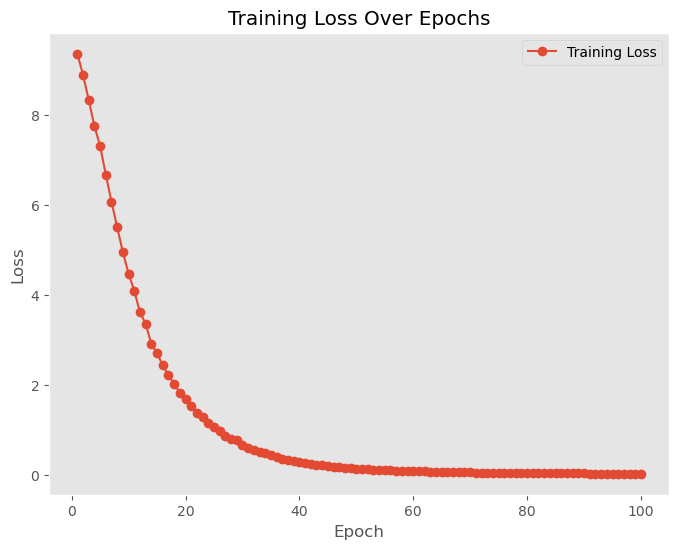

In [51]:
num_epochs = 100  # Define the number of epochs
train(num_epochs, "basic_math_problem_encoder", "basic_math_problem_decoder")

## Generate heatmap

This function allows us to visualise attention weights as a **heatmap**, helping us analyse which input tokens the decoder focuses on while generating each output token in our model. Using Matplotlib, it plots the attention_matrix as a color-coded intensity map, where darker shades indicate stronger attention at specific positions. This visualisation is helpful for allowing us to understand how our model prioritises different parts of the input, making it inciteful when attempting to optimise our attention mechanism. 

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention(input_tokens, output_tokens, attention_matrix):
    """
    Plot the attention weights as a heatmap.

    Args:
        input_tokens (list of str): Tokens in the input sequence.
        output_tokens (list of str): Tokens in the output sequence.
        attention_matrix (np.array): Attention weights matrix (output_tokens x input_tokens).
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_matrix, cmap="viridis", interpolation="nearest")
    plt.xticks(ticks=np.arange(len(input_tokens)), labels=input_tokens, rotation=45, ha="right")
    plt.yticks(ticks=np.arange(len(output_tokens)), labels=output_tokens)
    plt.colorbar(label="Attention Weight")
    plt.xlabel("Input Tokens")
    plt.ylabel("Output Tokens")
    plt.title("Attention Heatmap")
    plt.tight_layout()
    plt.show()

## Test setup

This function allow us to test our trained model by encoding our math question input sentence into hidden states and decoding it step-by-step to generate our expected answer. It tokenises the input using a predefined vocabulary and passes it through the encoder, which extracts a contextual representation. The decoder then predicts each output token using an iterative approach, incorporating attention weights to dynamically focus on relevant parts of the input. The function tracks attention matrices, enabling visualisation of how the model distributes focus across tokens. It prints the input sentence, generated output, and attention shape, and optionally plots a heatmap for deeper analysis. The final output is a list of predicted words, representing the answer to our math problem, which can then be evaluated for accuracy.

In [53]:
def test(encoder, decoder, input_sentence, word_to_index, index_to_word, max_target_length=100, with_attention_plot=False):
    # Set the models to evaluation mode
    encoder.eval()
    decoder.eval()
    # Tokenise the input sentence
    input_tokens = [word_to_index[word] for word in input_sentence.split()]
    input_seq = torch.tensor(input_tokens, dtype=torch.long).unsqueeze(0)  # Add batch dimension
    # Forward pass through the encoder
    encoder_outputs, (hidden, cell) = encoder(input_seq)
    # initialise the decoder
    decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE_TOKEN]], dtype=torch.long)  # Start-of-Sequence token
    decoder_hidden = hidden
    decoder_cell = cell
    # Generate output sequence and collect attention weights
    output_sequence = []
    attention_matrices = []

    for _ in range(max_target_length):
        output, decoder_hidden, decoder_cell, attention_weights = decoder(
            decoder_input, decoder_hidden, decoder_cell, encoder_outputs
        )
        predicted_token = output.argmax(1).item()  # Get the token with the highest probability

        if predicted_token == word_to_index[END_OF_SEQUENCE_TOKEN]:  # Stop at End-of-Sequence token
            break

        output_sequence.append(predicted_token)
        attention_matrices.append(attention_weights.cpu().detach().numpy())  # Save attention weights
        decoder_input = torch.tensor([predicted_token], dtype=torch.long)  # Next decoder input

    # Convert input and output tokens to words
    input_sentence_tokens = [index_to_word[token] for token in input_tokens]
    output_sentence_tokens = [index_to_word[token] for token in output_sequence]
    # Stack attention matrices into a 2D array (output_tokens x input_tokens)
    attention_matrix = np.vstack(attention_matrices)
    # Print the input and output sentences
    print("Input Sentence:", input_sentence_tokens)
    print("Generated Sentence:", output_sentence_tokens)
    print("Attention Weights Shape:", attention_matrix)
    # Visualise attention
    if with_attention_plot:
        # Plot the attention weights
        plot_attention(input_sentence_tokens, output_sentence_tokens, attention_matrix)

    # Convert token indices to words
    return [index_to_word[token] for token in output_sequence]

## Test the trained model - basic approach

Here we load our pre-trained sequence-to-sequence model for solving basic math word problems. We first initialises the encoder and decoder architectures with the same parameters used during training, ensuring consistency. Then, we load the pretrained model weights from the associated **.pth** files, restoring previously learned knowledge. After defining a sample input sentence, **"two plus four"**, we set up **word-to-index** and **index-to-word** mappings, allowing tokenisation and conversion between words and numerical indices. Finally, the test function is called, running the encoder-decoder model on the input question to generate a predicted answer while optionally visualising attention weights so we can attempt analyse how the model focuses on different tokens.

In [54]:
# load the trained model
input_size = len(word_to_index)  # Same as during training
output_size = len(word_to_index)
hidden_size = 128  # Same as during training
# Initialise the encoder and decoder
encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size)
# Load the trained weights
encoder.load_state_dict(torch.load("basic_math_problem_encoder.pth"))
decoder.load_state_dict(torch.load("basic_math_problem_decoder.pth"))

input_sentence = "two plus four"

word_to_index = {START_OF_SEQUENCE_TOKEN: 0, END_OF_SEQUENCE_TOKEN: 1, PADDING_SEQUENCE_TOKEN: 2, "two": 3, "plus": 4, "four": 5, "equals": 6, "six": 7, "three": 8, "minus": 9, "one": 10}
index_to_word = {v: k for k, v in word_to_index.items()}  # Reverse mapping for decoding

# Test and visualise
test(encoder, decoder, input_sentence, word_to_index, index_to_word)

Input Sentence: ['two', 'plus', 'four']
Generated Sentence: ['<SOS>', 'equals', 'six']
Attention Weights Shape: [[7.9253243e-07 1.0255497e-03 9.9897373e-01]
 [1.6303393e-06 1.5309759e-03 9.9846739e-01]
 [8.8157964e-07 1.1764759e-03 9.9882263e-01]]


['<SOS>', 'equals', 'six']

## Establish a baseline vocabulary and tokenisation capability

Here we set up a dynamic tokenisation function for our model by defining a baseline vocabulary containing special tokens (<SOS>, <EOS>, <PAD>). The function processes an input sentence by splitting words, checking if they already exist in the **word_to_index** mapping, and assigning a new index to any unseen words. This ensures that the vocabulary expands dynamically as new words are encountered, allowing the model to handle previously unknown input without predefined restrictions, with the function ultimately generating a list of token indices.

In [55]:
# Define special tokens for sequence processing - initially, the vocabulary only contains special tokens (<SOS>, <EOS>, <PAD>)
word_to_index = {START_OF_SEQUENCE_TOKEN: 0, END_OF_SEQUENCE_TOKEN: 1, PADDING_SEQUENCE_TOKEN: 2}  

def tokenise(sentence, word_to_index):
    """
    tokenises a sentence and dynamically updates the vocabulary mapping.
    Args:
        sentence (str): The input sentence to be tokenised.
        word_to_index (dict): Dictionary mapping words to unique indices.
    Returns:
        list: A list of token indices representing the sentence.
    """
    tokens = []  # Stores tokenised word indices

    # Process each word in the sentence
    for word in sentence.lower().split():
        # Add unseen words to the vocabulary and assign a unique index
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)  
        
        # Append the tokenised index to the token list
        tokens.append(word_to_index[word])

    return tokens  # Return tokenised sentence as a list of indices

## Load CSV dataset from file

Here we load a dataset of math questions and their associated answers from our previously generated CSV file, using Pandas. The function reads the CSV file into a DataFrame, extracts the "Question" column (math word question) and "Answer" column (corresponding answers), and returns them as lists. The script then specifies **"simple_math_problems_addition_only.csv"** as the dataset and calls the function to populate **input_sentences** and **target_sentences**, which can be tokenised and fed into the model for training and evaluation.

In [ ]:
import pandas as pd
import re

def clean_question_and_answer_data(text):
    """
    Cleans text by converting to lowercase, removing special characters, and stripping whitespace.
    Args:
        text (str): Input text to be cleaned.
    Returns:
        str: Cleaned text.
    """
    if isinstance(text, str):
        # Convert to lowercase for consistency
        text = text.lower()  
        # Regular expression to remove special characters except basic math symbols
        text = re.sub(r"[^a-z0-9+\-*/= ]", "", text)
        # Remove extra whitespace
        text = text.strip()  
        return text
    return ""


def load_question_and_answer_sequences_from_csv(csv_file):
    """
    Loads math problem sequences from a CSV file with error handling.
    Args:
        csv_file (str): Path to the CSV file containing math problems and solutions.
    Returns:
        tuple: Two lists containing problem statements and their corresponding solutions.
    """
    try:
        # Attempt to read the CSV file
        df = pd.read_csv(csv_file)
        # Check if required columns exist
        required_columns = {"Question", "Answer"}
        if not required_columns.issubset(df.columns):
            raise ValueError(f"Missing required columns: {required_columns - set(df.columns)}")
        # Handle missing values by dropping rows with NaN values in necessary columns
        df = df.dropna(subset=["Question", "Answer"])
        # Apply text cleaning function to both columns
        df["Question"] = df["Question"].apply(clean_question_and_answer_data)
        df["Answer"] = df["Answer"].apply(clean_question_and_answer_data)
        # Convert cleaned sequences to lists
        input_sentences = df["Question"].tolist()
        target_sentences = df["Answer"].tolist()
        # Return the question and answer sequence lists
        return input_sentences, target_sentences 
    # File not found error
    except FileNotFoundError:
        print(f"Error: The file '{csv_file}' was not found.") 
        return [], []
    # Handle missing columns or other value errors
    except ValueError as ve: 
        print(f"Error: {ve}")
        return [], []
    # Catch-all for any other exceptions
    except Exception as e: 
        print(f"Unexpected error: {e}")
        return [], []

# Specify the dataset file name
csv_file = "math_word_problems.csv"
# Load question and answer sequences
question_sequences, answer_sequences = load_question_and_answer_sequences_from_csv(csv_file)

## Tokenise input and target sentences and convert into tensors

We now tokenise the question and answer sentences and convert them into PyTorch tensors, preparing them for processing in a sequence-to-sequence model. It first transforms input sentences into numerical token lists using a predefined vocabulary (**word_to_index**). For target sentences, thus ensuring a structured decoding by appending **<SOS>** at the beginning and **<SOS>** at the end, guiding the model in output generation. A reverse mapping (**index_to_word**) is also created, allowing numerical tokens to be converted back into words for interpretation. Finally, both input and target tokenised sequences are converted into PyTorch tensors, ensuring they are formatted correctly for our models training and inference requirements. 

In [ ]:
def create_input_and_target_sequences(question_sequences, answer_sequences):
    """
    Creates tokenised input and target sequences from the loaded sentences.
    Args:
        input_sentences (list of str): List of math problems.
        target_sentences (list of str): List of corresponding solutions.
    Returns:
        tuple: Two lists containing tokenised input and target sequences.
    """
    # Tokenise input sentences by converting words to numerical indices
    input_data = [tokenise(sentence, word_to_index) for sentence in input_sentences]
    # Tokenise target sentences while adding <SOS> (start token) and <EOS> (end token)
    target_data = [[word_to_index[START_OF_SEQUENCE_TOKEN]] + 
                   tokenise(sentence, word_to_index) + 
                   [word_to_index[END_OF_SEQUENCE_TOKEN]] 
                   for sentence in target_sentences]
    
    return input_data, target_data  # Return both tokenised sequences

# Tokenise the question and answer sequences and create input-target pairs
input_data, target_data = create_input_and_target_sequences(question_sequences, answer_sequences) 
# Create a reverse mapping dictionary to convert token indices back into words
index_to_word = {v: k for k, v in word_to_index.items()}
# Convert tokenised sentences into PyTorch tensors for model compatibility
question_tensors = [torch.tensor(seq) for seq in input_data]  # Convert question sequences to tensors
answer_tensors = [torch.tensor(seq) for seq in target_data]  # Convert answer sequences to tensors

## Generate the math problem dataset from the tokensied data, including padding

This code prepares a dataset of math word problems for our sequence-to-sequence learning model, ensuring uniform sequence lengths using dynamic padding. The input and target sequences are padded with a special token **<PAD>** to maintain consistency in batch processing. The **DynamicMathWordProblemDataset** class organises the padded data into a PyTorch-compatible format, allowing efficient access to input-target pairs. The dataset is then wrapped in a PyTorch , which facilitates batch-wise loading of data, enabling smooth training with a batch size of **64**. By disabling shuffling, the sequences maintain their original order, optimising structured learning.

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# Apply dynamic padding to ensure uniform sequence length
questions_padded = pad_sequence(question_tensors, batch_first=True, padding_value=word_to_index[PADDING_SEQUENCE_TOKEN])
answers_padded = pad_sequence(answer_tensors, batch_first=True, padding_value=word_to_index[PADDING_SEQUENCE_TOKEN])

class MathWordProblemDataset(Dataset):
    """
    A PyTorch Dataset for padded math word problems.
    This class stores input and target sequences that have been padded 
    to a fixed length, ensuring consistency in batch processing.
    """
    def __init__(self, questions_padded, answers_padded):
        """
        initialises the dataset with padded sequences.
        Args:
            input_padded (Tensor): Padded input sequences.
            target_padded (Tensor): Padded target sequences.
        """
        self.input_data = questions_padded  # Store padded input sequences
        self.target_data = answers_padded  # Store padded target sequences

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        Returns:
            int: Total number of input-target pairs.
        """
        return len(self.input_data)

    def __getitem__(self, idx):
        """
        Retrieves a padded input-target pair as tensors.
        Args:
            idx (int): Index of the data sample.
        Returns:
            Tuple[Tensor, Tensor]: Padded input and target sequences.
        """
        return self.input_data[idx], self.target_data[idx]

# Create a dataset instance using the padded sequences
dataset = MathWordProblemDataset(questions_padded, answers_padded)
# initialise a DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)  # Batch size of 64, shuffle disabled for sequential processing

## Establish hyperparamters

We now set-up the hyperparameters for our trainining model. We first initialise the encoder and decoder models with a hidden size of **256**, then a **cross-entropy loss function** is defined with **ignore_index**, ensuring that our padding tokens do not affect training. Both models use the Adam optimiser with a learning rate of **0.0005** to adjust weights and improve performance. Finally, the we define training for **100** epochs, allowing saving of the learned model parameters under specified filenames for later inference.

Epoch 1/100, Loss: 5.8604
Epoch 2/100, Loss: 3.6223
Epoch 3/100, Loss: 3.3407
Epoch 4/100, Loss: 2.6902
Epoch 5/100, Loss: 2.2518
Epoch 6/100, Loss: 1.9590
Epoch 7/100, Loss: 1.7839
Epoch 8/100, Loss: 1.5834
Epoch 9/100, Loss: 1.4599
Epoch 10/100, Loss: 1.3700
Epoch 11/100, Loss: 1.2388
Epoch 12/100, Loss: 1.1402
Epoch 13/100, Loss: 1.0596
Epoch 14/100, Loss: 0.9744
Epoch 15/100, Loss: 0.8868
Epoch 16/100, Loss: 0.8720
Epoch 17/100, Loss: 0.8289
Epoch 18/100, Loss: 0.7179
Epoch 19/100, Loss: 0.6352
Epoch 20/100, Loss: 0.6175
Epoch 21/100, Loss: 0.5960
Epoch 22/100, Loss: 0.4859
Epoch 23/100, Loss: 0.4818
Epoch 24/100, Loss: 0.4381
Epoch 25/100, Loss: 0.4454
Epoch 26/100, Loss: 0.3675
Epoch 27/100, Loss: 0.3465
Epoch 28/100, Loss: 0.3589
Epoch 29/100, Loss: 0.3165
Epoch 30/100, Loss: 0.3611
Epoch 31/100, Loss: 0.2627
Epoch 32/100, Loss: 0.2517
Epoch 33/100, Loss: 0.2412
Epoch 34/100, Loss: 0.2419
Epoch 35/100, Loss: 0.2778
Epoch 36/100, Loss: 0.2240
Epoch 37/100, Loss: 0.1786
Epoch 38/1

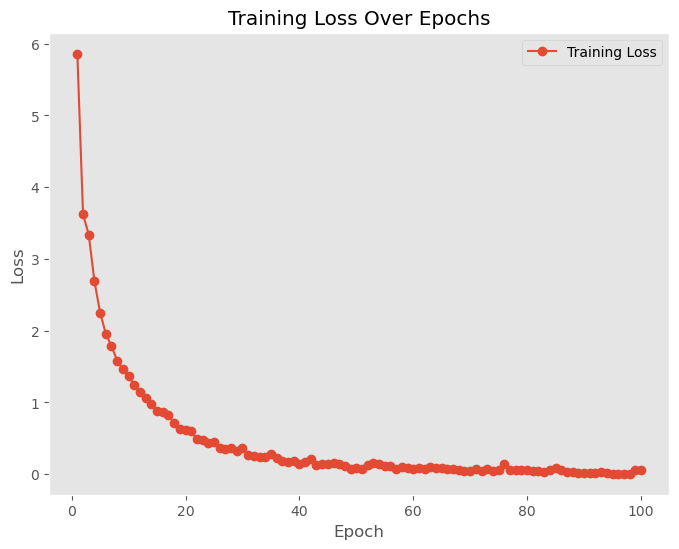

In [59]:
# Select the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define model parameters
input_size = len(word_to_index)  # Vocabulary size for the encoder
output_size = len(word_to_index)  # Vocabulary size for the decoder (same as input)
hidden_size = 256  # Number of hidden units in encoder and decoder
# initialise the encoder and move it to the selected device
encoder = Encoder(input_size, hidden_size).to(device)
# initialise the decoder and move it to the selected device
decoder = Decoder(output_size, hidden_size).to(device)
# Define the loss function (CrossEntropyLoss), ignoring padding tokens during training
criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PADDING_SEQUENCE_TOKEN]) 
# Set up Adam optimisers for both encoder and decoder with a learning rate of 0.0005
encoder_optimiser = optim.Adam(encoder.parameters(), lr=0.0005)
decoder_optimiser = optim.Adam(decoder.parameters(), lr=0.0005)
# Define the number of epochs for training
num_epochs = 100  
# Start the training process with specified epoch count and model save names
train(num_epochs, "math_problem_encoder", "math_problem_decoder")

# Test the revised model

We'll load our previously trained model, restoring the encoder and decoder models using their saved weights. Next we initialise the models with our predefined hyperparameters and load the previously trained model states using **torch.load()**. We then setup a question input (**"thirty-eight plus twenty-six"**) to test the model's ability to predict the correct outputted answer (**"sixty-four"**). The **test()** function runs inference, generating predictions from the trained model and optionally visualising the attention mechanism, allowing inspection of a heatmap that focuses on different parts of the input when making predictions.

{'<SOS>': 0, '<EOS>': 1, '<PAD>': 2, 'sam': 3, 'has': 4, '2': 5, 'marbles': 6, 'and': 7, 'he': 8, 'loses': 9, '14': 10, '-': 11, 'how': 12, 'many': 13, 'does': 14, 'have': 15, 'left?': 16, 'a': 17, 'baker': 18, '9': 19, 'muffins': 20, 'bakes': 21, 'more': 22, 'the': 23, 'now?': 24, 'train': 25, 'travels': 26, '17': 27, 'miles': 28, 'in': 29, 'morning': 30, 'evening': 31, 'what': 32, 'is': 33, 'total': 34, 'distance': 35, 'traveled?': 36, 'there': 37, 'are': 38, '8': 39, 'pencils': 40, 'one': 41, 'box': 42, '13': 43, 'another': 44, 'altogether?': 45, 'if': 46, '11': 47, 'apples': 48, 'added': 49, 'to': 50, '16': 51, 'total?': 52, '4': 53, 'store': 54, 'sells': 55, '19': 56, 'candies': 57, '12': 58, 'left': 59, 'were': 60, 'sold': 61, '3': 62, '20': 63, '6': 64, '15': 65, '7': 66, '18': 67, '10': 68, '5': 69, 'shop': 70, 'toys': 71, 'on': 72, 'monday': 73, 'tuesday': 74, '1': 75, 'sixteen': 76, 'twenty-three': 77, 'twenty-six': 78, 'twenty-one': 79, 'twenty-seven': 80, 'seventeen': 81, '

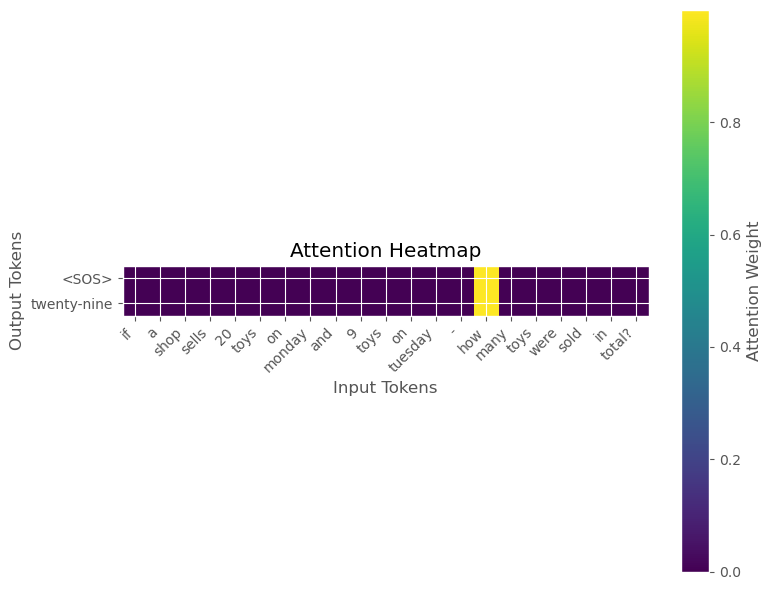

In [60]:
print(word_to_index)
# load the trained model
input_size = len(word_to_index)  # Same as during training
output_size = len(word_to_index)
hidden_size = 256  # Same as during training
# Initialise the encoder and decoder
encoder = Encoder(input_size, hidden_size)
decoder = Decoder(output_size, hidden_size)
# Load the trained weights
encoder.load_state_dict(torch.load("math_problem_encoder.pth"))
decoder.load_state_dict(torch.load("math_problem_decoder.pth"))
#create our test question
input_sentence = "if a shop sells 20 toys on monday and 9 toys on tuesday - how many toys were sold in total?" #sixty five
# Test and visualise
test_token_indices_to_words = test(encoder, decoder, input_sentence, word_to_index, index_to_word, with_attention_plot=True)

## Generate the test predictions for evaluation

We look to generate predictions using our trained sequence-to-sequence model and evaluate its performance using 'edit distance'. Edit distance is a measure of how different our sequences are from each other, calculated by the minimum number of operations required to transform one sequence into another. A lower edit distance indicates that the two sequences are highly similar, while a higher edit distance suggests greater differences. The **generate_predictions** function processes an input question, tokenises it into indices, and runs it through the encoder to obtain hidden states, which are then passed to the decoder. The decoder iteratively predicts the answer tokens, stopping when the **<EOS>** token is encountered. The predicted answer tokens are converted back into words for interpretation. The **evaluate_with_edit_distance** function allows us to compare generated outputs with ground truth sentences by computing the edit distance, which quantifies the differences between predictions and expected answers. The final output is the average edit distance, helping us to assess model accuracy when solving math word problems.

In [61]:
import edit_distance

def generate_predictions(encoder, decoder, input_sentence, word_to_index, index_to_word, max_target_length=10):
    """
    Generates a predicted output sequence for a given input sentence using a trained encoder-decoder model.
    Args:
        encoder: Trained encoder model.
        decoder: Trained decoder model.
        input_sentence (str): The input sentence to be processed.
        word_to_index (dict): Mapping of words to numerical token indices.
        index_to_word (dict): Reverse mapping of indices to words.
        max_target_length (int): Maximum length of the output sequence.
    Returns:
        list: A list of words representing the predicted output sequence.
    """
    encoder.eval()  # Set encoder to evaluation mode
    decoder.eval()  # Set decoder to evaluation mode

    # tokenise the input sentence by converting words to numerical token indices
    input_tokens = [word_to_index[word] for word in input_sentence.split()]
    input_seq = torch.tensor(input_tokens, dtype=torch.long).unsqueeze(0)  # Convert to tensor and add batch dimension
    # Forward pass through the encoder to obtain hidden and cell states
    encoder_outputs, (hidden, cell) = encoder(input_seq)
    # initialise decoder with <SOS> token as the first input
    decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE_TOKEN]], dtype=torch.long)
    decoder_hidden, decoder_cell = hidden, cell  # Use encoder outputs to initialise decoder states
    
    # Generate output sequence iteratively
    output_sequence = []
    for _ in range(max_target_length):
        # Pass current decoder input through the decoder
        output, decoder_hidden, decoder_cell, _ = decoder(
            decoder_input, decoder_hidden, decoder_cell, encoder_outputs
        )
        # Get the token with the highest probability from the decoder output
        predicted_token = output.argmax(1).item()
        # Stop generation if <EOS> token is predicted
        if predicted_token == word_to_index[END_OF_SEQUENCE_TOKEN]:
            break
        # Append the predicted token to the output sequence
        output_sequence.append(predicted_token)
        # Use predicted token as the next decoder input
        decoder_input = torch.tensor([predicted_token], dtype=torch.long)

    # Convert token indices back into words for interpretation
    return [index_to_word[token] for token in output_sequence]


def evaluate_with_edit_distance(test_data, encoder, decoder, word_to_index, index_to_word):
    """
    Evaluates the sequence-to-sequence model using edit distance.
    Args:
        test_data (list): List of (input_sentence, ground_truth_sentence) pairs.
        encoder: Trained encoder model.
        decoder: Trained decoder model.
        word_to_index (dict): Word-to-index mapping.
        index_to_word (dict): Index-to-word mapping.
    Returns:
        float: Average edit distance across the test dataset.
    """
    total_distance = 0  # initialise total edit distance accumulator
    for input_sentence, ground_truth_sentence in test_data:
        # Generate predicted sequence for the input sentence
        predicted_sentence = generate_predictions(encoder, decoder, input_sentence, word_to_index, index_to_word)
        # Compute edit distance between ground truth and predicted sentence
        distance = edit_distance.SequenceMatcher(a=ground_truth_sentence, b=predicted_sentence).distance()
        total_distance += distance  # Accumulate total distance
        # Debugging: Print example results for verification
        print(f"Input: {input_sentence}")
        print(f"Ground Truth: {ground_truth_sentence}")
        print(f"Predicted: {predicted_sentence}")
        print(f"Edit Distance: {distance}\n")

    # Compute average edit distance across the dataset
    average_distance = total_distance / len(test_data)
    print(f"Average Edit Distance: {average_distance}")

    return average_distance  # Return evaluation metric

## Evaluate using edit distance

We'll setup a small test dataset consisting of math word problems and their expected answers, formatted as tokenised sequences with a start token (**<SOS>**). We'll evaluate the trained model using 'edit distance' (as described above). Each test case follows a structured pattern where a simple math question is presented in text, and associated with the corresponding answer, again in text format. The **evaluate_with_edit_distance** is called to generate answer predictions and compare them against the ground truth answers. Finally, we calculate the average edit distance across all test cases, with the aim of assessing model accuracy.

In [62]:
# Define an example test dataset with math addition problems and expected solutions
test_data = [
    ("there are 12 pencils in one box and 19 pencils in another box - how many pencils are there altogether?", [START_OF_SEQUENCE_TOKEN, "thirty-one"]),  # Expected output: "thirty-one"
    ("there are 1 pencils in one box and 1 pencils in another box - how many pencils are there altogether?", [START_OF_SEQUENCE_TOKEN, "two"]),  # Expected output: "two"
    ("a baker has 5 muffins and bakes 14 more muffins - how many muffins does the baker have now?", [START_OF_SEQUENCE_TOKEN, "nineteen"]), # Expected output: "nineteen"
    ("a baker has 14 muffins and bakes 7 more muffins - how many muffins does the baker have now?", [START_OF_SEQUENCE_TOKEN, "twenty-one"]),  # Expected output: "twenty-one"
    ("a baker has 2 muffins and bakes 4 more muffins - how many muffins does the baker have now?", [START_OF_SEQUENCE_TOKEN, "six"]),  # Expected output: "six"
    ("if 7 apples are added to 3 apples - how many apples are there in total?", [START_OF_SEQUENCE_TOKEN, "ten"]),  # Expected output: "ten"
    ("a train travels 3 miles in the morning and 20 miles in the evening - what is the total distance traveled?", [START_OF_SEQUENCE_TOKEN, "twenty-three"]),  # Expected output: "twenty-three"
    ("if a shop sells 2 toys on monday and 18 toys on tuesday - how many toys were sold in total?", [START_OF_SEQUENCE_TOKEN, "twenty"]), # Expected output: "twenty"
    ("sam has 2 marbles and he loses 4 marbles - how many marbles does sam have left?", [START_OF_SEQUENCE_TOKEN, "six"])  # Expected output: "six"
]

# Evaluate the trained sequence-to-sequence model using edit distance
average_distance = evaluate_with_edit_distance(
    test_data, encoder, decoder, word_to_index, index_to_word
)

# Print the final average edit distance to assess model performance
print(f"Final Average Edit Distance: {average_distance}")

Input: there are 12 pencils in one box and 19 pencils in another box - how many pencils are there altogether?
Ground Truth: ['<SOS>', 'thirty-one']
Predicted: ['<SOS>', 'thirty-one']
Edit Distance: 0

Input: there are 1 pencils in one box and 1 pencils in another box - how many pencils are there altogether?
Ground Truth: ['<SOS>', 'two']
Predicted: ['<SOS>', 'two']
Edit Distance: 0

Input: a baker has 5 muffins and bakes 14 more muffins - how many muffins does the baker have now?
Ground Truth: ['<SOS>', 'nineteen']
Predicted: ['<SOS>', 'nineteen']
Edit Distance: 0

Input: a baker has 14 muffins and bakes 7 more muffins - how many muffins does the baker have now?
Ground Truth: ['<SOS>', 'twenty-one']
Predicted: ['<SOS>', 'twenty-one']
Edit Distance: 0

Input: a baker has 2 muffins and bakes 4 more muffins - how many muffins does the baker have now?
Ground Truth: ['<SOS>', 'six']
Predicted: ['<SOS>', 'six']
Edit Distance: 0

Input: if 7 apples are added to 3 apples - how many apples are 

## Add positional encodings to our encode model

We look to further extend our original encoder model with the addition of a positional encoding layer to inject sequential information. Positional encodings allow us to enforce built-in order awareness, ensuring that questions and answers maintain their relative positioning within a given sequence.
Thes encodings are implemented using learned embeddings, which generate continuous patterns that help the model differentiate token positions. The intention here is to ensure the model can effectively understand and retain the order of words, improving context understanding, translation accuracy, and sentence structure in an attempt to improve training accuracy.

In [63]:
class Encoder(nn.Module):
    """
    An LSTM-based encoder with positional encodings for sequence-to-sequence tasks.
    This model encodes input sequences using embeddings, positional encodings, 
    and a stacked LSTM, returning hidden and cell states for use by a decoder.
    """
    def __init__(self, input_size, hidden_size, dropout=0.1, max_seq_len=100):
        """
        initialises the encoder model.
        Args:
            input_size (int): Vocabulary size (number of unique tokens).
            hidden_size (int): Dimensionality of hidden states in the LSTM.
            dropout (float): Dropout rate for regularisation.
            max_seq_len (int): Maximum sequence length for positional encodings.
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        # Embedding layer to convert token indices into dense vectors
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Positional encodings to retain word order information
        self.positional_encodings = nn.Embedding(max_seq_len, hidden_size)
        # LSTM layer for sequential processing with batch support
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        # Dropout for regularisation to prevent overfitting
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_seq):
        """
        Forward pass of the encoder.
        Args:
            input_seq (Tensor): Tensor containing input token indices with shape (batch_size, seq_length).
        Returns:
            Tuple[Tensor, Tuple[Tensor, Tensor]]: LSTM outputs and final hidden & cell states.
        """
        # Generate positional indices for the input sequence
        positions = torch.arange(0, input_seq.size(1), device=input_seq.device).unsqueeze(0)
        # Retrieve positional encodings for each token position
        positional_enc = self.positional_encodings(positions)
        # Compute embeddings, add positional encodings, and apply dropout
        embedded = self.dropout(self.embedding(input_seq) + positional_enc)
        # Process embedded input sequence through the LSTM
        outputs, (hidden, cell) = self.lstm(embedded)

        return outputs, (hidden, cell)  # Return LSTM outputs and final hidden/cell states

## Tune hyperparameters using Opuna

This code utilises Optuna, a powerful hyperparameter optimisation framework, to fine-tune an encoder-decoder model for sequence-to-sequence tasks. The **objective** function defines the hyperparameters to be optimised, including hidden size, learning rate, and dropout rate, which are sampled across a predefined range. It then initialises the encoder and decoder models with these parameters, applies dropout regularisation, and sets up cross-entropy loss while ignoring padding tokens. The models are trained for one epoch with teacher forcing, where the actual target sequence is used as input to the decoder, helping accelerate learning. The script runs 30 trials, minimising loss to find the best-performing hyperparameter combination, which is then printed for further experimentation. We aslo provide visualisations of the hyperparameter tuning process, which should help to identify trends in model performance based on different parameter values, with plots including an optimisation history graph that tracks how loss decreases across trials, a hyperparameter importance chart highlighting which parameters most affect performance, and a loss vs. hyperparameter relationships plot to visualise individual parameter effects. The final visualisation offers insights into how different hidden sizes, learning rates, and dropout rates impact model accuracy, enabling informed decisions on optimal configurations.

[I 2025-04-09 18:48:14,870] A new study created in memory with name: no-name-d3af7ec6-04bf-4d18-84c6-15ffe2f9e88d
[I 2025-04-09 18:48:29,976] Trial 0 finished with value: 10.368316415756468 and parameters: {'hidden_size': 408, 'learning_rate': 4.2793342547604467e-05, 'dropout_rate': 0.2202632204824263}. Best is trial 0 with value: 10.368316415756468.
[I 2025-04-09 18:48:41,260] Trial 1 finished with value: 4.190036402808295 and parameters: {'hidden_size': 247, 'learning_rate': 0.0036854104323857427, 'dropout_rate': 0.33180684607551536}. Best is trial 1 with value: 4.190036402808295.
[I 2025-04-09 18:48:45,705] Trial 2 finished with value: 4.151025817507789 and parameters: {'hidden_size': 184, 'learning_rate': 0.008168014008141634, 'dropout_rate': 0.2678870542954067}. Best is trial 2 with value: 4.151025817507789.
[I 2025-04-09 18:48:53,852] Trial 3 finished with value: 10.523100360991462 and parameters: {'hidden_size': 268, 'learning_rate': 6.980821776005667e-05, 'dropout_rate': 0.3551

Best hyperparameters: {'hidden_size': 411, 'learning_rate': 0.005562195764471198, 'dropout_rate': 0.21693646966725472}


C:\Users\sohegarty\AppData\Local\Temp\ipykernel_33844\1757033414.py:81: ExperimentalWarning:

plot_slice is experimental (supported from v2.2.0). The interface can change in the future.



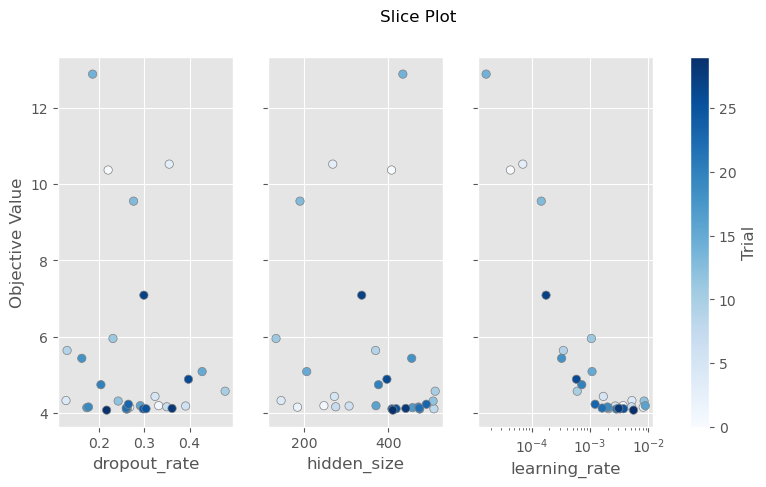

In [64]:
import optuna
import torch.optim as optim

# Objective function for hyperparameter tuning
def objective(trial):
    """
    Defines the optimisation objective for hyperparameter tuning using Optuna.
    Args:
        trial (optuna.Trial): A single optimisation trial where hyperparameters are sampled.
    Returns:
        float: The averaged loss computed over one epoch, which Optuna minimises.
    """
    # Suggest hyperparameters for tuning
    hidden_size = trial.suggest_int("hidden_size", 128, 512)  # Hidden layer size
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # Log-scaled learning rate
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)  # Dropout rate for regularisation
    # initialise encoder-decoder models with suggested hyperparameters
    encoder = Encoder(input_size, hidden_size).to(device)
    decoder = Decoder(output_size, hidden_size).to(device)
    # Apply dropout in LSTM layers for both models
    encoder.lstm.dropout = dropout_rate
    decoder.lstm.dropout = dropout_rate
    # Define loss function, ignoring padding tokens in label sequences
    criterion = nn.CrossEntropyLoss(ignore_index=word_to_index[PADDING_SEQUENCE_TOKEN])
    # Set up Adam optimisers with the suggested learning rate
    encoder_optimiser = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimiser = optim.Adam(decoder.parameters(), lr=learning_rate)
    # initialise total loss for tracking performance
    total_loss = 0

    # Run one epoch of training to evaluate hyperparameter performance
    for input_seq, target_seq in dataloader:
        # Move data to the selected device (CPU/GPU)
        input_seq, target_seq = input_seq.to(device), target_seq.to(device)
        # Reset gradients before forward pass
        encoder_optimiser.zero_grad()
        decoder_optimiser.zero_grad()
        # Forward pass through encoder to obtain initial hidden states
        encoder_outputs, (hidden, cell) = encoder(input_seq)
        # initialise decoder input with <SOS> token for each sequence in batch
        decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE_TOKEN]] * input_seq.size(0), device=device)
        decoder_hidden, decoder_cell = hidden, cell  # Set decoder states from encoder outputs

        loss = 0  # Track cumulative loss across target sequence

        for t in range(target_seq.size(1)):  # Iterate over target sequence length
            # Forward pass through decoder
            output, decoder_hidden, decoder_cell, _ = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs
            )

            # Compute loss for current timestep
            loss += criterion(output, target_seq[:, t])
            # Apply teacher forcing: use ground-truth target as next input
            decoder_input = target_seq[:, t]

        # Backpropagate loss and update optimiser
        loss.backward()
        encoder_optimiser.step()
        decoder_optimiser.step()

        total_loss += loss.item()  # Accumulate total loss

    return total_loss / len(dataloader)  # Return average loss per batch for Optuna optimisation

# Create Optuna study for hyperparameter tuning (minimising loss)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  # Run 30 trials to find the best parameters
# Extract best-performing hyperparameters from optimisation results
best_params = study.best_params
print("Best hyperparameters:", best_params)
# Store best hyperparameter values for model training
best_hidden_size = best_params["hidden_size"]
best_learning_rate = best_params["learning_rate"]
best_dropout_rate = best_params["dropout_rate"]
# Plot optimization history (loss over trials)
optuna.visualization.plot_optimization_history(study)
# Plot relationship between hyperparameters
optuna.visualization.plot_param_importances(study)
# Additional plots (Loss vs. specific hyperparameters)
fig = optuna.visualization.matplotlib.plot_slice(study)
plt.show()  # Display plots

## Train with k-fold

We look to further improvements by implementing **k-fold cross-validation** for training our model.

K-fold cross-validation is a technique used to evaluate a model’s generalisation ability by splitting the dataset into multiple equal-sized folds (typically 5, as in our case). The model is trained on (k-1) folds while the remaining 1 fold is used for validation, ensuring every data point is tested at least once. This process repeats (k) times, each time using a different fold as the validation set. The final performance metric is the average over all iterations, making this method highly effective in reducing bias and variance compared to simple train-test splits. It helps us assess how well our model performs on unseen data, ensuring reliable real-world predictions.

To achieve this, we split our dataset into multiple folds (default: 5), ensuring each portion is used for both training and validation, which helps to assess model generalisation. During each fold, the encoder and decoder weights are reset, trained for multiple epochs using teacher forcing, and optimised with Adam optimisers. After training, the validation step computes loss while ignoring padded tokens, ensuring evaluation accuracy. The trained models are then saved per fold for further analysis. Finally, the **evaluate_model** function calculates validation loss, ensuring we have some means of performance tracking.

In [70]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset

def train_with_k_fold(encoder: Encoder, decoder: Decoder, num_epochs, batch_size, weight_init, learning_rate, k_folds=5):
    """
    Implements k-fold cross-validation for training a sequence-to-sequence model 
    and returns the best encoder and decoder instead of saving each fold.
    Args:
        encoder (Encoder): Initialized encoder model.
        decoder (Decoder): Initialized decoder model.
        num_epochs (int): Number of epochs per fold.
        batch_size (int): Training batch size.
        weight_init (function): Function to initialize model weights.
        learning_rate (float): Learning rate for optimization.
        k_folds (int): Number of folds for cross-validation.
    Returns:
        best_encoder (Encoder): The best encoder model based on validation loss.
        best_decoder (Decoder): The best decoder model based on validation loss.
    """
    # Create KFold object for splitting dataset into `k_folds` subsets
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    validation_results = []  # Stores validation loss for each fold
    best_encoder = None  # Placeholder for best encoder model
    best_decoder = None  # Placeholder for best decoder model
    best_loss = float("inf")  # Initialize best validation loss as infinity
    # Track current fold number
    fold_index = 1  
    # Iterate through each fold
    for train_indices, val_indices in kfold.split(dataset):
        # Create subsets for training and validation
        train_data = Subset(dataset, train_indices)
        val_data = Subset(dataset, val_indices)
        # Create DataLoaders for batch processing
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
        # Print fold information
        print(f"Training fold {fold_index}/{k_folds}...")
        # Reset model weights before training on a new fold
        encoder.apply(weight_init)
        decoder.apply(weight_init)
        # Initialize optimizers with the specified learning rate
        encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
        decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
        # Training loop
        for epoch in range(num_epochs):
            epoch_loss = 0  # Track loss for current epoch
            for input_seq, target_seq in train_loader:
                # Move tensors to device (GPU or CPU)
                input_seq, target_seq = input_seq.to(device), target_seq.to(device)
                # Reset gradients before forward pass
                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()
                # Forward pass through encoder
                encoder_outputs, (hidden, cell) = encoder(input_seq)
                # Initialize decoder input with <SOS> token for batch processing
                decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE_TOKEN]] * input_seq.size(0), device=device)
                decoder_hidden, decoder_cell = hidden, cell  # Encoder outputs initialize decoder states
                # Compute sequence lengths for each target batch (ignoring padding)
                target_lengths = (target_seq != word_to_index[PADDING_SEQUENCE_TOKEN]).sum(dim=1)
                max_target_length = target_lengths.max().item()  # Find longest sequence in batch
                 # Track cumulative batch loss
                loss = 0 
                # Decoding loop (teacher forcing)
                for t in range(max_target_length):
                    still_active = t < target_lengths  # Ensure valid sequence length
                    if not still_active.any():
                        break
                    # Forward pass through decoder
                    output, decoder_hidden, decoder_cell, _ = decoder(
                        decoder_input, decoder_hidden, decoder_cell, encoder_outputs
                    )
                    # Compute loss while ignoring padded sequences
                    loss += (criterion(output, target_seq[:, t]) * still_active.float()).sum() / still_active.sum()
                    # Apply teacher forcing (use actual target token as next input)
                    decoder_input = target_seq[:, t]

                # Backpropagate gradients and update model parameters
                loss.backward()
                encoder_optimizer.step()
                decoder_optimizer.step()
                epoch_loss += loss.item()  # Accumulate epoch loss
            
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")
            
        # Evaluate performance on validation set
        val_loss = evaluate_model(val_loader)
        print(f"Validation Loss for fold {fold_index}: {val_loss:.4f}")
        # Store validation loss for current fold
        validation_results.append((fold_index, val_loss))
         # Vocabulary size for the encoder
        input_size = len(word_to_index) 
        # If current fold has better validation loss, update best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_encoder = Encoder(input_size, best_hidden_size)  # Reinitialize encoder
            best_decoder = Decoder(input_size, best_hidden_size)  # Reinitialize decoder
            best_encoder.load_state_dict(encoder.state_dict())  # Copy trained weights
            best_decoder.load_state_dict(decoder.state_dict())
        # Move to next fold
        fold_index += 1  
    # Find and print the best fold
    best_fold = min(validation_results, key=lambda x: x[1])[0]
    print(f"Best model found in fold {best_fold} with Validation Loss: {best_loss:.4f}")
    # Return best-performing models
    return best_encoder, best_decoder  


def evaluate_model(dataloader):
    """
    Evaluates the model on the validation or test dataset and computes loss.
    Args:
        dataloader (DataLoader): DataLoader for validation or test samples.
    Returns:
        float: Average loss over all batches.
    """
    encoder.eval()  # Set encoder to evaluation mode
    decoder.eval()  # Set decoder to evaluation mode
    # Initialize validation loss accumulator
    val_loss = 0  
    # Disable gradient computation for evaluation
    with torch.no_grad():  
        for input_seq, target_seq in dataloader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            # Generate encoder outputs
            encoder_outputs, (hidden, cell) = encoder(input_seq)
            # Initialize decoder input with <SOS> token
            decoder_input = torch.tensor([word_to_index[START_OF_SEQUENCE_TOKEN]] * input_seq.size(0), device=device)
            decoder_hidden, decoder_cell = hidden, cell  # Use encoder outputs for decoder initialization
            # Compute sequence lengths for target batch
            target_lengths = (target_seq != word_to_index[PADDING_SEQUENCE_TOKEN]).sum(dim=1)
            max_target_length = target_lengths.max().item()
            # Iterate over target sequence length
            for t in range(max_target_length):
                still_active = t < target_lengths  # Ensure valid sequence length
                if not still_active.any():
                    break
                # Forward pass through decoder
                output, decoder_hidden, decoder_cell, _ = decoder(
                    decoder_input, decoder_hidden, decoder_cell, encoder_outputs
                )
                # Compute validation loss while ignoring padded sequences
                val_loss += (criterion(output, target_seq[:, t]) * still_active.float()).sum().item() / still_active.sum().item()
                # Teacher forcing: Use actual target token as next input
                decoder_input = target_seq[:, t]
    # Return average validation loss
    return val_loss / len(dataloader)  

## Implement hyperparameter changes and re-test

Finally, we initialise and train our revised model using hyperparameter-tuned values and k-fold cross-validation to enhance generalisation. It first sets-up the encoder and decoder models using the best hyperparameters obtained from tuning (**hidden_size**, **dropout_rate**, and **learning_rate**), and applies cross-entropy loss with ignored padding tokens to prevent irrelevant data from influencing training. The Adam optimiser refines both models, ensuring efficient weight adjustments. We then invoke **k-fold cross-validation** (5 folds), systematically splitting the dataset into training and validation subsets, enabling performance tracking across different data partitions. Each fold resets model weights, trains for 100 epochs, evaluates validation performance, and saves the trained models.

In [ ]:
def weight_init(m):
    """
    Initializes the weights of a neural network layer using Xavier Uniform initialization.
    This ensures that the weights are properly scaled to maintain stable gradients during training.
    Args:
        m: A module (e.g., a layer in the neural network) whose weights will be initialized.
    """
    for param in m.parameters():  # Iterate over all parameters in the module
        if param.dim() > 1:  # Check if the parameter has more than one dimension (e.g., weight matrices)
            nn.init.xavier_uniform_(param)  # Apply Xavier Uniform initialization to multi-dimensional parameters

# Initialize the encoder and decoder with the tuned hyperparameters
tuned_encoder = Encoder(input_size, hidden_size=best_hidden_size, dropout=best_dropout_rate).to(device)
tuned_decoder = Decoder(output_size, hidden_size=best_hidden_size, dropout=best_dropout_rate).to(device)
# Select the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Train using k-fold cross-validation (ensures better generalization)
best_encoder, best_decoder = train_with_k_fold(
    tuned_encoder,
    tuned_decoder,
    num_epochs=100,  # Number of epochs for training
    batch_size=32,   # Mini-batch size for training
    weight_init=weight_init,  # Weight initialization parameter
    learning_rate=best_learning_rate,  # Optimized learning rate from tuning
    k_folds=min(2, len(dataset))  # Ensure the number of folds does not exceed the number of samples
)

print('best encoder and decoder loaded')

Training fold 1/2...
Epoch 1/100, Loss: 284.9440
Epoch 2/100, Loss: 223.9184
Epoch 3/100, Loss: 220.8326
Epoch 4/100, Loss: 208.1025
Epoch 5/100, Loss: 172.4429
Epoch 6/100, Loss: 152.2793
Epoch 7/100, Loss: 129.5287
Epoch 8/100, Loss: 110.6488
Epoch 9/100, Loss: 108.1119
Epoch 10/100, Loss: 96.0555
Epoch 11/100, Loss: 85.1071
Epoch 12/100, Loss: 75.0724
Epoch 13/100, Loss: 69.2158
Epoch 14/100, Loss: 61.6104
Epoch 15/100, Loss: 56.7404
Epoch 16/100, Loss: 60.5647
Epoch 17/100, Loss: 50.8591
Epoch 18/100, Loss: 43.7973
Epoch 19/100, Loss: 39.6069
Epoch 20/100, Loss: 33.5295
Epoch 21/100, Loss: 33.6421
Epoch 22/100, Loss: 36.7995
Epoch 23/100, Loss: 28.8895
Epoch 24/100, Loss: 22.0813
Epoch 25/100, Loss: 16.1071
Epoch 26/100, Loss: 12.8721
Epoch 27/100, Loss: 11.0683
Epoch 28/100, Loss: 8.8664
Epoch 29/100, Loss: 9.2176
Epoch 30/100, Loss: 7.4932
Epoch 31/100, Loss: 8.3630
Epoch 32/100, Loss: 9.4670
Epoch 33/100, Loss: 8.0799
Epoch 34/100, Loss: 6.4181
Epoch 35/100, Loss: 5.4183
Epoch 3

KeyboardInterrupt: 

: 

## Evaluate using BLEU score

Batch 1 BLEU Score: 100.0000
Batch 2 BLEU Score: 100.0000
Batch 3 BLEU Score: 41.1134
Batch 4 BLEU Score: 100.0000
Batch 5 BLEU Score: 41.1134
Batch 6 BLEU Score: 100.0000
Batch 7 BLEU Score: 100.0000
Batch 8 BLEU Score: 100.0000
Batch 9 BLEU Score: 100.0000
Batch 10 BLEU Score: 100.0000
Batch 11 BLEU Score: 100.0000
Batch 12 BLEU Score: 100.0000
Batch 13 BLEU Score: 41.1134
Batch 14 BLEU Score: 100.0000
Batch 15 BLEU Score: 100.0000
Batch 16 BLEU Score: 100.0000
Batch 17 BLEU Score: 100.0000
Batch 18 BLEU Score: 100.0000
Batch 19 BLEU Score: 100.0000
Batch 20 BLEU Score: 100.0000
Batch 21 BLEU Score: 100.0000
Batch 22 BLEU Score: 100.0000
Batch 23 BLEU Score: 100.0000
Batch 24 BLEU Score: 41.1134
Batch 25 BLEU Score: 41.1134
Batch 26 BLEU Score: 100.0000
Batch 27 BLEU Score: 100.0000
Batch 28 BLEU Score: 100.0000
Batch 29 BLEU Score: 100.0000
Batch 30 BLEU Score: 100.0000
Batch 31 BLEU Score: 100.0000
Batch 32 BLEU Score: 41.1134
Batch 33 BLEU Score: 41.1134
Batch 34 BLEU Score: 100.0

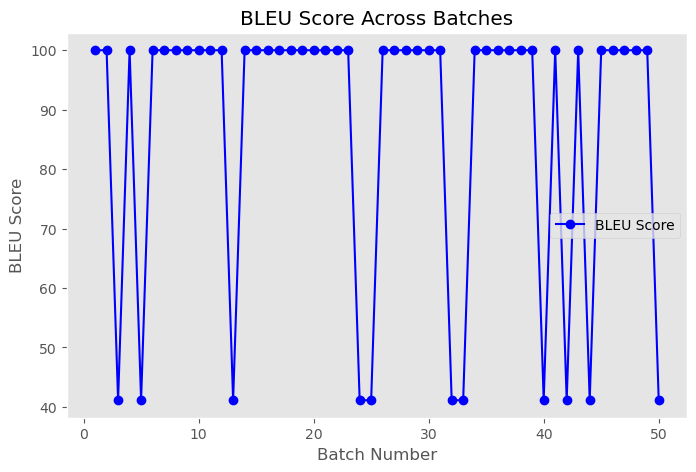

Overall BLEU Score: 100.0000


100.00000000000004

In [ ]:
import sacrebleu

def evaluate_BLEU_score_for_model(encoder, decoder, dataloader, max_target_len, device, word_to_index, index_to_word):
    """
    Evaluates the performance of a trained sequence-to-sequence model using BLEU score and plots its trends.
    Args:
        encoder (Encoder): Trained encoder model.
        decoder (Decoder): Trained decoder model.
        dataloader (DataLoader): DataLoader containing test data.
        max_target_len (int): Maximum length of the output sequence.
        device: Torch device (CPU or GPU).
        word_to_index (dict): Dictionary mapping words to indices.
        index_to_word (dict): Dictionary mapping indices to words.
    Returns:
        float: BLEU score representing translation accuracy.
    """
    encoder.eval()  # Set encoder to evaluation mode
    decoder.eval()  # Set decoder to evaluation mode

    bleu_scores = []  # Stores BLEU scores per batch
    batch_indices = []  # Track batch numbers

    references = []  # Stores ground truth sequences
    candidates = []  # Stores model-generated sequences

    with torch.no_grad():  # Disable gradient calculations during evaluation
        for batch_idx, (input_seq, target_seq) in enumerate(dataloader):
            input_seq = input_seq.to(device)  # Move input tensor to the correct device
            # Forward pass through the encoder to obtain output representations
            encoder_output = encoder(input_seq)
            encoder_outputs, (hidden, cell) = encoder_output  # Unpack hidden states
            # Initialize decoder input with <SOS> token for batch processing
            decoder_input = torch.tensor([word_to_index["<SOS>"]] * input_seq.size(0), device=device)
            decoder_hidden, decoder_cell = hidden, cell  # Use encoder outputs to initialize decoder states
            # Stores predicted sequences per instance
            predictions = [[] for _ in range(input_seq.size(0))]  
            # Iterate through the target sequence length
            for _ in range(max_target_len):
                # Forward pass through decoder
                output, decoder_hidden, decoder_cell, _ = decoder(
                    decoder_input, decoder_hidden, decoder_cell, encoder_outputs
                )
                # Retrieve the most probable token from the decoder output
                top_token = output.argmax(1)
                # Append predicted tokens to individual sequence lists
                for i, token in enumerate(top_token.tolist()):
                    predictions[i].append(token)
                # Stop decoding if all sequences generate <EOS>
                if all(token == word_to_index["<EOS>"] for token in top_token.tolist()):
                    break
                # Update decoder input with the predicted token
                decoder_input = top_token
            # Convert predicted and target sequences to readable word format
            predicted_seqs = [" ".join([index_to_word[token] for token in seq]) for seq in predictions]
            target_seqs = [" ".join([index_to_word[token.item()] for token in target_seq[i]]) for i in range(target_seq.size(0))]
            # Wrap references in lists for BLEU score calculation
            references.extend([[ref] for ref in target_seqs])
            # Store model-predicted sequences
            candidates.extend(predicted_seqs)  
            # Compute BLEU score for this batch
            batch_bleu_score = sacrebleu.corpus_bleu(predicted_seqs, [[ref] for ref in target_seqs]).score
            bleu_scores.append(batch_bleu_score)
            batch_indices.append(batch_idx + 1)
            # Print batch BLEU score for monitoring
            print(f"Batch {batch_idx + 1} BLEU Score: {batch_bleu_score:.4f}")

    # Plot BLEU scores across batches
    plt.figure(figsize=(8, 5))
    plt.plot(batch_indices, bleu_scores, marker='o', linestyle='-', color='b', label="BLEU Score")
    plt.xlabel("Batch Number")
    plt.ylabel("BLEU Score")
    plt.title("BLEU Score Across Batches")
    plt.legend()
    plt.grid()
    plt.show()
    # Compute overall BLEU score for the entire dataset
    overall_bleu_score = sacrebleu.corpus_bleu(candidates, references).score
    print(f"Overall BLEU Score: {overall_bleu_score:.4f}")
    # return the overall BLEU score for the dataset
    return overall_bleu_score


# Load test dataset and prepare sequences
csv_file = "test_math_word_problems.csv"
# Load problem and solution sequences from CSV file
input_sentences, target_sentences = load_sequences_from_csv(csv_file)
# Tokenize sentences and create input-target pairs
input_data, target_data = create_input_and_target_sequences(input_sentences, target_sentences)
# Create a reverse mapping dictionary to convert token indices back into words
index_to_word = {v: k for k, v in word_to_index.items()}
# Convert tokenized sentences into PyTorch tensors for model compatibility
input_tensors = [torch.tensor(seq) for seq in input_data]  # Convert input sequences to tensors
target_tensors = [torch.tensor(seq) for seq in target_data]  # Convert target sequences to tensors
# Apply dynamic padding to ensure uniform sequence lengths
input_padded = pad_sequence(input_tensors, batch_first=True, padding_value=word_to_index[PADDING_SEQUENCE_TOKEN])
target_padded = pad_sequence(target_tensors, batch_first=True, padding_value=word_to_index[PADDING_SEQUENCE_TOKEN])
# Create a dataset instance using the padded sequences
dataset = DynamicMathWordProblemDataset(input_padded, target_padded)
# Initialize a DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=40, shuffle=True)  # Process in batches of 40 for efficiency
# Evaluate BLEU score using the best model obtained from k-fold training
evaluate_BLEU_score_for_model(best_encoder, best_decoder, dataloader, max_target_len=10, 
                              device=device, word_to_index=word_to_index, index_to_word=index_to_word)